<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Решеные задачи:**

1. Использовал [датасет](https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv) японских машин, обучил модель предсказывать цены на японские автомобили.
2. Создал обучающую, тестовую и проверочную выборки.
3. Оценил качество работы созданной сети, определил средний процент ошибки на проверочной выборке.
4. В качестве ошибки использовал среднеквадратическую ошибку (mse).



In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2024-05-25 11:41:05--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv.1’

japan_cars_dataset. 100%[===================>] 133.53K   314KB/s    in 0.4s    

2024-05-25 11:41:06 (314 KB/s) - ‘japan_cars_dataset.csv.1’ saved [136735/136735]



In [ ]:
import pandas as pd
cars = pd.read_csv('japan_cars_dataset.csv', sep=',')

# Удалим строки с пустыми значениями
cars = cars.dropna()

# Выводим первые 10 машин
cars.head(10)

,Unnamed: 0,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
0,0,80,nissan,march,2003,80000,1240,at,2wd,rhd,gasoline
1,1,110,nissan,march,2010,53000,1200,at,2wd,rhd,gasoline
2,2,165,nissan,lafesta,2005,47690,2000,at,2wd,rhd,gasoline
3,3,190,toyota,avensis,2008,130661,1990,at,2wd,rhd,gasoline
4,4,190,daihatsu,mira,2006,66300,660,at,2wd,rhd,gasoline
5,5,190,daihatsu,mira,2004,81400,660,at,2wd,rhd,gasoline
6,8,220,nissan,march,2010,117000,1200,at,2wd,rhd,gasoline
7,9,230,volkswagen,passat,2008,127763,3190,at,4wd,rhd,gasoline
8,10,275,mazda,bongo van,2010,178218,1800,mt,2wd,rhd,gasoline
9,11,283,honda,step wgn,2005,121655,2000,at,2wd,rhd,gasoline


In [ ]:
# ваше решение
import numpy as np
from keras import utils
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [ ]:
cars['mark_model'] = cars['mark'] + ' ' + cars['model']
cars.drop(cars.columns[[0]], axis= 1, inplace= True)
# Перемешивание строк DataFrame
cars = cars.sample(frac=1)
cars.head(10)

,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel,mark_model
432,690,honda,accord,2006,109450,1990,at,4wd,rhd,gasoline,honda accord
604,790,honda,fit,2003,66000,1300,at,2wd,rhd,gasoline,honda fit
1725,1213,toyota,bb,2007,54907,1300,at,2wd,rhd,gasoline,toyota bb
1480,1120,nissan,bluebird sylphy,2006,42000,1990,at,2wd,rhd,gasoline,nissan bluebird sylphy
637,790,honda,fit,2004,109000,1300,at,2wd,rhd,gasoline,honda fit
1921,1280,toyota,alphard,2004,104822,2400,at,2wd,rhd,gasoline,toyota alphard
2240,1381,toyota,ractis,2011,64758,1300,at,2wd,rhd,gasoline,toyota ractis
2164,1353,toyota,ist,2003,81613,1500,at,2wd,rhd,gasoline,toyota ist
1344,1088,toyota,alphard v,2003,120758,2400,at,2wd,rhd,gasoline,toyota alphard v
1289,1054,toyota,raum,2003,134343,1500,at,2wd,rhd,gasoline,toyota raum


In [ ]:
def to_class(column):
  unique_list = cars[column].unique()

  result_list = []

  for uniq_str in unique_list:
    row_array = uniq_str.split(',')
    result_list = list(set(result_list + row_array))

  result_class = {}

  for index, value in enumerate(result_list):
    result_class[value] = index

  return result_class

In [ ]:
# Текстовые значения
mark_model_class = to_class('mark_model')
transmission_class = to_class('transmission')
drive_class = to_class('drive')
hand_drive_class = to_class('hand_drive')
fuel_class = to_class('fuel')

In [ ]:
# Числовые значения
# Список порогов годов
year_class = [1970, 1980, 1990, 1995, 2000, 2005, 2010]

# Список порогов пробега
mileage_class = [1000, 5000, 10000, 50000, 100000, 150000, 200000, 500000]

# Список порогов для двигателя
engine_class = [500, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]

In [ ]:
def range2OHE(param, class_list):

   # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(class_list)+1

    # Поиск интервала для входного значения
    for i in range(num_classes - 1):
        if float(param) < class_list[i]:
            cls = i                       # Интервал найден, выбор класса
            break
    else:
        cls = num_classes - 1             # Интервал не найден, выбор последнего класса

    # Возврат в виде one hot encoding-вектора
    return utils.to_categorical(cls, num_classes)

In [ ]:
def str2multiOHE(param, class_dict):

    # Определение размерности выходного вектора, как число уникальных классов
    num_classes = len(set(class_dict.values()))

    # Создание нулевого вектора
    result = np.zeros(num_classes)

    # Если не смогли распарсить, то поле не заполнено
    # Устанавливаем значение по умолчанию (последний элемент в словаре)
    if not isinstance(param, str):
        param = list(class_dict.keys())[-1]

    # Поиск значения в словаре и, если нашли, то проставляем 1 в найденной позиции
    for value, cls in class_dict.items():
        if value in param:
            result[cls] = 1.

    return result

In [ ]:
COL_YEAR = cars.columns.get_loc('year')
COL_MILEAGE = cars.columns.get_loc('mileage')
COL_ENG = cars.columns.get_loc('engine_capacity')
COL_TRANSM = cars.columns.get_loc('transmission')
COL_DRIVE = cars.columns.get_loc('drive')
COL_HDRIVE = cars.columns.get_loc('hand_drive')
COL_FUEL = cars.columns.get_loc('fuel')
COL_MARKMODEL = cars.columns.get_loc('mark_model')
COL_PRICE = cars.columns.get_loc('price')

def get_row_data(row):
    # Объединение всех входных данных в один общий вектор
    x_data = np.hstack([
                range2OHE(row[COL_YEAR], year_class),
                range2OHE(row[COL_MILEAGE], mileage_class),
                range2OHE(row[COL_ENG], engine_class),
                str2multiOHE(row[COL_TRANSM], transmission_class),
                str2multiOHE(row[COL_DRIVE], drive_class),
                str2multiOHE(row[COL_HDRIVE], hand_drive_class),
                str2multiOHE(row[COL_FUEL], fuel_class),
                str2multiOHE(row[COL_MARKMODEL], mark_model_class)
              ])

    # Вектор стоимости
    y_data = np.array([row[COL_PRICE]]) / 100


    return x_data, y_data

def get_train_data(dataFrame):
    x_data = []
    y_data = []

    for row in dataFrame.values:
        x, y = get_row_data(row)
        x_data.append(x)
        y_data.append(y)

    return np.array(x_data), np.array(y_data)

In [ ]:
x_train, y_train = get_train_data(cars)

In [ ]:
# Для нормализации данных используется готовый инструмент
y_scaler = StandardScaler()

# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

In [ ]:
print(x_train.shape, y_train.shape)

(2318, 307) (2318, 1)


In [ ]:
input1 = Input((x_train.shape[1],))

x = input1
x = Dense(20, activation="relu")(x)
x = Dense(500, activation="relu")(x)
x = Dense(400, activation="relu")(x)
x = Dense(300, activation="relu")(x)
x = Dense(200, activation="relu")(x)
x = Dense(30, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)
model = Model(input1, x)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = model.fit(x_train[:1800],
                           y_train_scaled[:1800],
                           batch_size=64,
                           epochs=100,
                           validation_data=(x_train[1800:], y_train_scaled[1800:]),
                           verbose=1)

Epoch 1/100
29/29 [==============================] - 4s 38ms/step - loss: 0.9861 - mae: 0.8346 - val_loss: 0.9675 - val_mae: 0.8356
Epoch 2/100
29/29 [==============================] - 1s 22ms/step - loss: 0.9377 - mae: 0.8171 - val_loss: 0.9268 - val_mae: 0.8171
Epoch 3/100
29/29 [==============================] - 1s 27ms/step - loss: 0.8795 - mae: 0.7880 - val_loss: 0.8887 - val_mae: 0.7971
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.8450 - mae: 0.7678 - val_loss: 0.8766 - val_mae: 0.7902
Epoch 5/100
29/29 [==============================] - 1s 24ms/step - loss: 0.8250 - mae: 0.7575 - val_loss: 0.8672 - val_mae: 0.7785
Epoch 6/100
29/29 [==============================] - 1s 24ms/step - loss: 0.8022 - mae: 0.7443 - val_loss: 0.8514 - val_mae: 0.7740
Epoch 7/100
29/29 [==============================] - 1s 31ms/step - loss: 0.8016 - mae: 0.7462 - val_loss: 0.8453 - val_mae: 0.7701
Epoch 8/100
29/29 [==============================] - 1s 30ms/step - loss: 0.

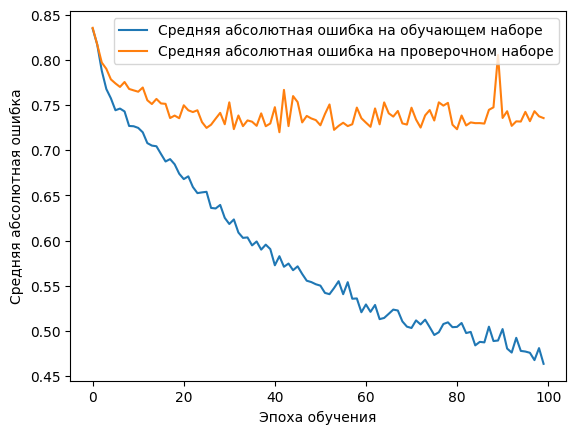

In [ ]:
plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

4/4 [==============================] - 0s 4ms/step
Средняя абсолютная ошибка: 2.4495501178741454 

Реальное значение:  13.06  Предсказанное значение:   9.05  Разница:   4.01
Реальное значение:  12.20  Предсказанное значение:  11.42  Разница:   0.78
Реальное значение:   8.00  Предсказанное значение:  12.08  Разница:   4.08
Реальное значение:   4.90  Предсказанное значение:   5.67  Разница:   0.77
Реальное значение:   6.07  Предсказанное значение:  11.33  Разница:   5.26
Реальное значение:  13.00  Предсказанное значение:  12.32  Разница:   0.68
Реальное значение:   5.00  Предсказанное значение:   8.81  Разница:   3.81
Реальное значение:  12.50  Предсказанное значение:  11.82  Разница:   0.68
Реальное значение:  12.41  Предсказанное значение:   8.21  Разница:   4.20
Реальное значение:  10.70  Предсказанное значение:   9.86  Разница:   0.84


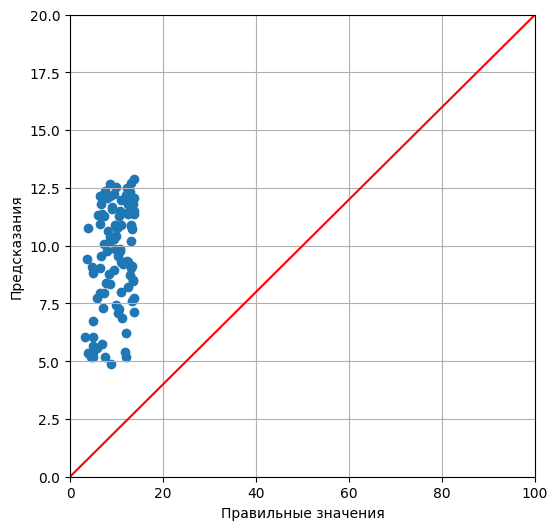

In [ ]:
pred = model.predict(x_train[1800:1900])

pred = y_scaler.inverse_transform(pred)    # Обратная нормированию процедура

print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train[1800:1900]), '\n') # расчет средней абсолютной ошибки

for i in range(10):
    print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[1800:1900][i, 0],
                                                                                                pred[i, 0],
                                                                                                abs(y_train[1800:1900][i, 0] - pred[i, 0])))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_train[1800:1900], pred)          # Отрисовка точечного графика
ax.set_xlim(0, 100)                           # Ограничение оси по x
ax.set_ylim(0, 20)                           # Ограничение оси по x
ax.plot(plt.xlim(), plt.ylim(), 'r')          # Отрисовка диагональной линии
plt.xlabel('Правильные значения')
plt.ylabel('Предсказания')
plt.grid()
plt.show()

In [ ]:
# Сохраняем для дальнейшего использования
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/My Drive/japan.h5')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Освобождение памяти от промежуточных данных
del history, model, pred